### What Does This Do?

This notebook is supposed to measure an unknown phase shift in a quantum circuit. This is done by introducing a superposition with a Haddamard gate, then making a phase change with a phase gate, before recombining the states with a second Haddamard gate.

### How Has This Been Done Before?

This is being done in a very similar way to what is known as a Ramsey Circuit. Ramsey circuits are broken up into a real and imaginary component, corresponding to and X and Y circuit. These measure the real and imaginary components of the phase that was introduced. Through some mathematical analysis using the atan2 function, the phase difference can be recovered.

### Imports

First, we need to import a number of tools from both qiskit and python. From qiskit, we need to import the tools to make, modify, and visualize our quantum circuit. From python we are importing a few general useful tools.

In [32]:
#import qiskit tools
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, Aer, IBMQ
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview
from qiskit.providers.aer import noise
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator


#import python stuff
import matplotlib.pyplot as plt
import numpy as np
import time
import math

We then also need to load the IBMQ account if it has not been loaded already. Here we also select the quantum computer that we actually want to run this circuit on. Much of the code for running this circuit on the quantum computer has been taken from the CHSH Bell Inequality Jupyter Notebook.

In [36]:
# Set devices, if using a real device
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
quito = provider.get_backend('ibmq_belem')

ibmqfactory.load_account:WARNING:2021-10-09 17:01:29,810: Credentials are already in use. The existing account in the session will be replaced.


Here we initialize our first quantum circuit and place the necessary gates. We are adding two Haddamard gates and a phase gate. This is used to measure the real component of the phase. Following this, we will run the circuit on the chosen quantum computer.

In [4]:
qreg_q = QuantumRegister(1, 'q')
creg_c = ClassicalRegister(1, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

simulator = QasmSimulator()

In [21]:
circuit.reset(qreg_q[0])


circuit.h(qreg_q[0])
circuit.p(np.pi/2, qreg_q[0])
# circuit.sdg(qreg_q[0])
circuit.h(qreg_q[0])


circuit.measure(qreg_q[0], creg_c[0])

compiled_circuit = transpile(circuit, simulator)


In [6]:
job = simulator.run(compiled_circuit, shots = 1000)
result = job.result()

counts = result.get_counts(compiled_circuit)
print("\nTotal count for 00 and 11 are:", counts)


Total count for 00 and 11 are: {'0': 1000}


In [24]:
# Execute and get counts

tic = time.time()
transpiled_circuit = transpile(circuit, quito) # transpile: compile onto a usable platform
job_real = quito.run(transpiled_circuit, shots=1000)
job_monitor(job_real)
result_real = job_real.result()
toc = time.time()

print(toc-tic)

Job Status: job has successfully run
12.632831811904907


In [38]:
# editor = CircuitComposer(circuit=circuit)
# editor

print(circuit)

<module 'qiskit.circuit' from '/opt/conda/lib/python3.8/site-packages/qiskit/circuit/__init__.py'>


Now that the job has been run on the quantum computer, we can collect the counts of each result to then later use them to find the phase. Here is plotted the real results.

In [25]:
counts = result_real.get_counts(circuit)
print(counts)

{'0': 531, '1': 469}


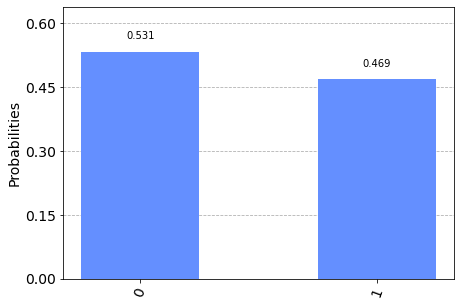

In [26]:
plot_histogram(counts)

In order to find the unknown phase, we need to run the second circuit to find the imaginary phase. This is accomplished by initiating a second circuit with an S dagger gate. This projects the imaginary plane onto the real plane so it can be measured.

In [10]:
qreg_q2 = QuantumRegister(1, 'q')
creg_c2 = ClassicalRegister(1, 'c')
circuit2 = QuantumCircuit(qreg_q2, creg_c2)

simulator2 = QasmSimulator()

In [11]:
circuit2.reset(qreg_q[0])


circuit2.h(qreg_q[0])
circuit2.p(np.pi/2, qreg_q[0])
circuit2.sdg(qreg_q[0])
circuit2.h(qreg_q[0])


circuit2.measure(qreg_q[0], creg_c[0])

compiled_circuit2 = transpile(circuit2, simulator2)

In [27]:
# Execute and get counts

tic = time.time()
transpiled_circuit2 = transpile(circuit2, quito) # transpile: compile onto a usable platform
job_real2 = quito.run(transpiled_circuit2, shots=1000)
job_monitor(job_real2)
result_real2 = job_real2.result()
toc = time.time()

print(toc-tic)

Job Status: job has successfully run
20.703677892684937


Once again, we will plot the results of this circuit. These are the imaginary results, the second component required to find the unknown phase.

In [28]:
counts2 = result_real2.get_counts(circuit2)
print(counts2)

{'0': 993, '1': 7}


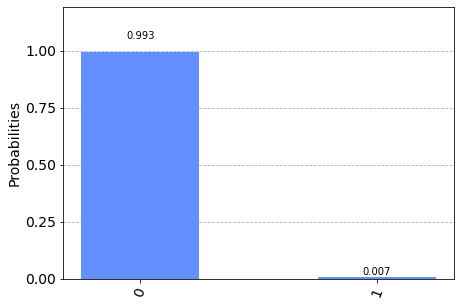

In [29]:
plot_histogram(counts2)

### Calculation of the Unknown Phase

Now that we have the results from the two quantum circuits, we can calculate the unknown phase. This is done by taking the difference of the 0 and 1 results from each the real and imaginary circuit. These are then normalized and plugged into the ATAN2 function to obtain the phase. Starting with the calculation of the differences:

In [31]:
real_difference = (counts["0"]*0.001) - (counts["1"]*0.001)

imaginary_difference = (counts2["0"]*0.001) - (counts2["1"]*0.001)


print(real_difference)
print(imaginary_difference)

0.062
0.986


Now we have to normalize these values, and then plug them into the ATAN2 function.

In [33]:
x_norm = (real_difference)/(math.sqrt((real_difference)**2 + (imaginary_difference)**2))
y_norm = (imaginary_difference)/(math.sqrt((real_difference)**2 + (imaginary_difference)**2))

print(x_norm)
print(y_norm)

0.0627563796106564
0.9980288757436646


In [34]:
phase = math.atan2(y_norm, x_norm)
print(phase)

1.5079986811054826


### Results

This value is very similar to the phase that was inserted into the circuit. The set phase is $\frac{\pi}{2}$, which is equivalent to about 1.57. This is not the exact same value because of the interference that is always present on a quantum computer. Noise of any sort will disrupt the exact accuracy of this measurement, but it is still very close. This program works as intended, as the phase was able to be recovered. In order for increased accuracy, implementation to run these circuits more times or on different systems could be beneficial.